# Исследовательский проект
### Дроздова Алёна БПИ229

## Веб-скрейпинг

In [437]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import seaborn as sns
from scipy.stats import norm

Объект моего исследования - книги из раздела "Самые популярные книги" сайт LiveLib.ru.
На каждой странице - 20 книг, поэтому сгенерируем список из ссылок на 20 первых страниц, воспользовавшись шаблоном ссылки

In [ ]:
links = []
for i in range(20):
    links.append(f"https://www.livelib.ru/books/movers-and-shakers/listview/biglist/~{i+1}")

С помощью библиотек напишем функцию для сбора списков ссылок с каждой страницы

In [ ]:
def get_urls(link):
    r = requests.get(link)
    page = BeautifulSoup(r.text, 'html.parser')
    urls = []
    for url in page.findAll("a", class_="book-item__title"):
        urls.append(url['href'])
    return urls

Соберём все 400 ссылок и дополним их до полной внешней ссылки. Также запишем их в файл urls.xlsx, чтобы впоследствие не собирать данные ещё раз

In [ ]:
urls = []
for link in links:
    urls += get_urls(link)
    sleep(3)
    print(f"{link} downloaded")
for i in range(len(urls)):
    urls[i] = "https://www.livelib.ru" + urls[i]
df_urls = pd.DataFrame(urls)
df_urls.columns = ["urls"]
df_urls.to_excel("urls.xlsx")

Теперь будем пользоваться созданным файлом. Считаем весь список ссылок из файла urls.xlsx

In [ ]:
links = pd.read_excel("urls.xlsx")["urls"].to_list()

Переходим непосредственно к веб-скреппингу. Напишем функции для сбора нужных нам данных. Для лучшей декомпозиции кода вынесем отдельно функции обработки рейтинга, статистики, жанра и информации о книге

In [194]:
def get_data(link):
    r = requests.get(link, proxies={"http":"http://10.10.1.10:3128"})
    r.encoding = 'utf8'
    page = BeautifulSoup(r.text, 'html.parser')
    heading = page.find("h1").get_text()
    author = page.find("h2", class_="bc-author").get_text().replace("\n", "")
    if len(page.findAll("a", class_="bc-edition__link"))>1:
        edition = page.findAll("a", class_="bc-edition__link")[1].get_text()
    else:
        edition = page.find("a", class_="bc-edition__link").get_text()
    stats = page.find("div", class_="bc-stat").get_text()
    rating = page.find("a", class_="bc-rating-medium").get_text()
    info = page.html.findAll("div", class_="bc-info__wrapper")[1].div.get_text()
    genre = page.html.findAll("div", class_="bc-info__wrapper")[2].div.get_text()
    return heading, author, edition, get_rating(rating), *get_stats(stats), get_genre(genre), *get_info(info)

In [172]:
def get_rating(rating):
    rating = rating.replace(" ","").replace(",", ".")
    return(float(rating.split("\n")[1]))

In [173]:
def get_stats(stats):
    stats = stats.replace("\xa0", "").replace(" ","").replace("\n\n", "\n").split("\n")
    n = len(stats)
    if n>=4:
        read = int(stats[1])
    if n>=6:
        plan = int(stats[3])
    else:
        plan = 0
    if n>=8:
        reviews = int(stats[6])
    else:
        reviews = 0
    if n>=11:
        quotes = int(stats[9])
    else:
        quotes = 0
    return read, plan, reviews, quotes

In [174]:
def get_genre(genre):
    genre = genre.replace(" ","").replace("\n\n", "\n").split("\n")[2]
    return genre.split(",\u2002")[0]

In [175]:
def get_info(info):
    info = info.replace(" ","").replace(":\n", ":").replace(":\t", ":").replace("\r", "").split("\n")
    isbn = None
    year = None
    pages = None
    language = None
    age_limit = None
    for i in info:
        if "ISBN" in i:
            isbn = i.replace("ISBN:","")
        if "Годиздания" in i:
            year = int(i.replace("Годиздания:",""))
        if ("Количествостраниц" in i) or ("Страниц" in i) or ("стр.," in i):
            pages = ''
            for char in i:
                if (not char.isdigit()) and pages != '':
                    break
                if char.isdigit():
                    pages = pages + char
            pages = int(pages)
        if "Язык:" in i:
            language = i.replace("Язык:", "")
        if "Возрастныеограничения" in i:
            age_limit = i[(i.find("Возрастныеограничения:")+22):(i.find("Возрастныеограничения:")+25)]
    return isbn, year, pages, language, age_limit

Последовательно (с паузами и конечно же sleep) соберём все необходимые нам данные. Я это делала в несколько дней, во избежание блокировки со стороны сервера, поэтому привожу итоговую функцию, а пользоваться будем уже готовым датасетом

In [ ]:
books = []
for i in range(0, 400):
    try:
        books.append(get_data(links[i]))
    except:
        print(f"Исключение при обработке {i} {links[i]}")
    sleep(30)
    if i % 5 == 4:
        print(f"{i+1}/400 downloaded")
        sleep(30)
print("Download successful!")
df_books = pd.DataFrame(books)
df_books.columns = ["heading", "author", "edition", "rating", "read", "planned", "reviews", "quotes", "genre", "ISBN", "year", "pages", "language", "age_limit"]
df_books.to_excel("books.xlsx")

Получаем следующий датасет:

In [270]:
df_books

,heading,author,edition,rating,read,planned,reviews,quotes,genre,ISBN,year,pages,language,age_limit
0,Илос. Начало,Лия Арден,"Потомки Первых, книга №3.5",4.6,1460,3300,46,83,Русскоефэнтези,978-5-04-164474-1,2022.0,448.0,Русский,16+
1,Цианид,Кристина Старк,Mainstream,4.2,2069,3920,92,270,Любовныероманы,978-5-17-146746-3,2022.0,448.0,Русский,NaN
2,Мистер Вечный Канун. Город Полуночи,"Владимир Торин, Олег Яковлев","Мистер Вечный Канун, книга №1",4.3,1321,3829,74,72,Русскоефэнтези,978-5-00195-790-4,2022.0,NaN,Русский,18+
3,Бес|смертный. Том 1,Кориандр,Эксмо,4.3,1111,2030,23,14,"Комиксы,манга,графическиероманы",978-5-04-110975-2,2022.0,176.0,Русский,18+
4,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Тацуки Фудзимото,\n 4 из 6\n ...,4.6,797,378,1,3,"Комиксы,манга,графическиероманы",978-5-389-21080-6,2022.0,392.0,Русский,18+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,Глазами альбатроса,Карл Сафина,Альпина нон-фикшн,4.5,14,186,3,2,Научно-популярнаялитература,978-5-00139-692-5,2022.0,NaN,Русский,NaN
393,Бэнкси,Березанская Мария,АСТ,4.7,12,49,0,0,Биографииимемуары,978-5-17-149357-8,2022.0,160.0,Русский,16+
394,Письма к Единорогу,Кристина Стрельникова,Время,4.7,13,65,6,12,Детскаяпроза,978-5-9691-2248-2,2022.0,NaN,Русский,NaN
395,Любовь внутри. Путь от одиночества к по-настоя...,Юн Кан Чэнь,Альпина Паблишер,3.5,28,231,1,0,Книгипопсихологии,978-5-9614-8064-1,2022.0,NaN,Русский,NaN


Мне данный датасет показался неинтересным, я захотела добавить в него ещё данные. Как известно, код ISBN - уникален для каждой книги, поэтому можно организовать автоматический поиск в каталоге читай города и при наличии данной книги там собрать дополнительные данные. Именно это и было мной сделано. В функции get_chitaigorod_info сначала выполняется поиск по коду, затем, при наличии результата, собирается информация о цене и характеристиках книги

In [255]:
def get_chitaigorod_info(isbn):
    r = requests.get("https://www.chitai-gorod.ru/search?q="+str(isbn), proxies={"http":"http://10.10.1.10:3128"})
    r.encoding = 'utf8'
    page = BeautifulSoup(r.text, 'html.parser')
    sleep(10)
    link = "https://www.chitai-gorod.ru"+page.find("a", class_="product-card__title")["href"]
    r = requests.get(link, proxies={"http":"http://10.10.1.10:3128"})
    r.encoding = 'utf8'
    page = BeautifulSoup(r.text, 'html.parser')
    price = page.find("span", class_="product-detail-offer-header__price-currency")["content"]
    try:
        old_price = page.find("span", class_="product-detail-offer-header__old-price").get_text().replace(" ", "").replace("₽", "").replace("\n", "")
    except:
        old_price = price
    info = page.html.find("div", class_="product-detail-info__characteristics-wrapper").get_text().replace(" ", "").replace("\n\n", ":").split(":")
    return price, old_price, info

Данная функция принимает на вход строку исходного датасета, получает новые данные и обрабатывает текстовый формат характеристики книги, на выходе возвращая строку новых, более полных данных

In [251]:
def get_newinfo(row):
    price, old_price, info = get_chitaigorod_info(row[9])
    edition, year, pages, language, age_limit = row[2], row[10], row[11], row[12], row[13]
    cover, weight, nums = None, None, None
    for i in range(len(info)):
        if info[i] == "Издательство":
            edition = info[i+1]
        if info[i] == "Количествостраниц":
            pages = int(info[i+1])
        if info[i] == "Вес,г":
            weight = int(info[i+1])
        if info[i] == "Возрастныеограничения":
            age_limit = info[i+1].replace("\n", "")
        if info[i] == "Годиздания":
            year = int(info[i+1])
        if info[i] == "Тираж":
            nums = int(info[i+1])
        if info[i] == "Типобложки":
            cover = info[i+1]
    return row[0], row[1], row[9], edition, age_limit, row[8], language, cover, year, int(price), int(old_price), pages, weight, nums, row[3], row[4], row[5], row[6], row[7], 


Данный этап веб-скрейпинга также выполнялся частями. Стоит отметить, что довольно много книг не входят в каталог Читай города, но тогда нам не хватает данных для анализа по ним, поэтому мы их не будем брать в итоговый датасет

In [272]:
books_new = []
books = pd.read_excel("books.xlsx", index_col=0).values.tolist()
for i in range(len(books)):
    try:
        books_new.append(get_newinfo(books[i]))
    except:
        print(f"Книги {books[i][0]} нет на сайте Читай города.")
    sleep(20)
    if i % 5 == 4:
        print(f"{i+1}/{len(books)} downloaded")
        sleep(30)
df = pd.DataFrame(books_new)
df.columns = ["heading", "author", "ISBN", "edition", "age_limit", "genre", "language", "cover_type", "year", "price", "old_price", "pages", "weight", "num_of_copies", "rating", "read", "planned", "reviews", "quotes"]
df.to_excel("books_new.xlsx")

Книги Спартак. Гладиатор нет на сайте Читай города.
Книги Воодушевление отделов продаж. Инструменты нематериальной мотивации нет на сайте Читай города.
55/397 downloaded
Книги Игра в метаморфозы нет на сайте Читай города.
60/397 downloaded
65/397 downloaded
Книги Пылающий нет на сайте Читай города.
70/397 downloaded
75/397 downloaded
Книги Я — Авейра. Том 1 нет на сайте Читай города.
80/397 downloaded
Книги Приплывший дом нет на сайте Читай города.
85/397 downloaded
90/397 downloaded
95/397 downloaded
Книги Арсен Люпен. Джентльмен-грабитель нет на сайте Читай города.
100/397 downloaded


Получили такой датасет, для каждой строки которого нам необходимо было собирать данные с трёх веб-страниц + изначальные 20 со всеми ссылками на книги

Удалим все строки с пустым ISBN, так как результатам поиска по пустоте доверять нельзя)

In [440]:
df = df.dropna(subset=['ISBN'])
df.reset_index(drop= True , inplace= True )
df.to_excel("books_new.xlsx")

In [441]:
df = pd.read_excel("books_new.xlsx", index_col=0)
df

,heading,author,ISBN,edition,age_limit,genre,language,cover_type,year,price,old_price,pages,weight,num_of_copies,rating,read,planned,reviews,quotes
0,Илос. Начало,Лия Арден,978-5-04-164474-1,INSPIRIA,16+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,690,690,448,541,18000.0,4.6,1460,3300,46,83
1,Цианид,Кристина Старк,978-5-17-146746-3,АСТ,18+,Любовныероманы,Русский,Твердыйпереплёт,2022,549,675,448,400,20000.0,4.2,2069,3920,92,270
2,Мистер Вечный Канун. Город Полуночи,"Владимир Торин, Олег Яковлев",978-5-00195-790-4,"Манн,ИвановиФербер",18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,723,925,576,556,3000.0,4.3,1321,3829,74,72
3,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Тацуки Фудзимото,978-5-389-21080-6,Азбука,18+,"Комиксы,манга,графическиероманы",Русский,Твердыйпереплёт,2022,944,944,392,530,40000.0,4.6,797,378,1,3
4,Песнь Сорокопута. Ренессанс,Фрэнсис Кель,978-5-04-164581-6,Эксмо,18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,608,745,480,439,5000.0,4.3,819,3093,30,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Моё настоящее имя. Истории с биографией,Людмила Улицкая,978-5-17-153632-9,АСТ,18+,Современнаярусскаялитература,Русский,Твердыйпереплёт,2023,797,975,285,320,17000.0,4.6,15,259,4,5
267,Предвестники Мельтиара,Влада Медведникова,978-5-6048361-9-4,PopcornBooks,18+,Современнаярусскаялитература,Русский,Мягкийпереплет,2023,424,623,336,306,10000.0,3.7,24,165,3,8
268,Бэнкси,Березанская Мария,978-5-17-149357-8,АСТ,12+,Биографииимемуары,Русский,NaN,2022,484,595,160,200,2000.0,4.7,12,49,0,0
269,Любовь внутри. Путь от одиночества к по-настоя...,Юн Кан Чэнь,978-5-9614-8064-1,АльпинаПаблишер,12+,Книгипопсихологии,Русский,Твердыйпереплёт,2023,491,779,204,400,2000.0,3.5,28,231,1,0


## Анализ полученного датасета

Опишем переменные данного датасета:

**Строковые данные**
- heading - название книги
- author - автор книги
- ISBN - уникальный код
- genre - жанр книги

**Категориальные данные**
- edition - издательство
- age_limit - ограничение по возрасту
- language - язык книги
- cover_type - тип обложки
- year - год издания
- sale - наличие скидки

**Количественные данные**
- price - стоимость книги (руб)
- old_price - исходная стоимость книги (отличается, если есть скидка)
- pages - количество страниц
- weight - вес книги (г)
- num_of_copies - тираж издания (шт)
- rating - средняя оценка на LiveLib.ru
- read - количество отметок о прочтении на LiveLib.ru
- planned - количество планирующих прочитать на LiveLib.ru
- reviews - количество рецензий на LiveLib.ru
- quotes - количество цитат на LiveLib.ru
- discount - размер скидки

In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   heading        271 non-null    object 
 1   author         267 non-null    object 
 2   ISBN           271 non-null    object 
 3   edition        271 non-null    object 
 4   age_limit      270 non-null    object 
 5   genre          267 non-null    object 
 6   language       271 non-null    object 
 7   cover_type     257 non-null    object 
 8   year           271 non-null    int64  
 9   price          271 non-null    int64  
 10  old_price      271 non-null    int64  
 11  pages          271 non-null    int64  
 12  weight         271 non-null    int64  
 13  num_of_copies  263 non-null    float64
 14  rating         271 non-null    float64
 15  read           271 non-null    int64  
 16  planned        271 non-null    int64  
 17  reviews        271 non-null    int64  
 18  quotes    

Выведем количество пустых значений

In [443]:
df.isna().sum()

heading           0
author            4
ISBN              0
edition           0
age_limit         1
genre             4
language          0
cover_type       14
year              0
price             0
old_price         0
pages             0
weight            0
num_of_copies     8
rating            0
read              0
planned           0
reviews           0
quotes            0
dtype: int64

Узнаем количество уникальных значений в каждом столбце, чтобы преобразовать некоторые данные в категориальные

In [444]:
df.nunique()

heading          271
author           247
ISBN             271
edition           30
age_limit          5
genre             73
language           2
cover_type         3
year               5
price            113
old_price         86
pages             64
weight           124
num_of_copies     25
rating            20
read             144
planned          235
reviews           41
quotes            55
dtype: int64

Как видно, удобно преобразовать столбцы edition, age_limit, language, cover_type, year

In [445]:
df["edition"] = df["edition"].astype('category')
df["age_limit"] = df["age_limit"].astype('category')
df["language"] = df["language"].astype('category')
df["cover_type"] = df["cover_type"].astype('category')
df["year"] = df["year"].astype('category')

Рассчитаем новый столбец - discount


$$\text{discount} = \frac{\text{old_price}-\text{price}}{\text{old_price}}*100\%$$

In [446]:
df['discount'] = round((df['old_price'] - df['price'])/df['old_price']*100, 2)
df

,heading,author,ISBN,edition,age_limit,genre,language,cover_type,year,price,old_price,pages,weight,num_of_copies,rating,read,planned,reviews,quotes,discount
0,Илос. Начало,Лия Арден,978-5-04-164474-1,INSPIRIA,16+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,690,690,448,541,18000.0,4.6,1460,3300,46,83,0.00
1,Цианид,Кристина Старк,978-5-17-146746-3,АСТ,18+,Любовныероманы,Русский,Твердыйпереплёт,2022,549,675,448,400,20000.0,4.2,2069,3920,92,270,18.67
2,Мистер Вечный Канун. Город Полуночи,"Владимир Торин, Олег Яковлев",978-5-00195-790-4,"Манн,ИвановиФербер",18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,723,925,576,556,3000.0,4.3,1321,3829,74,72,21.84
3,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Тацуки Фудзимото,978-5-389-21080-6,Азбука,18+,"Комиксы,манга,графическиероманы",Русский,Твердыйпереплёт,2022,944,944,392,530,40000.0,4.6,797,378,1,3,0.00
4,Песнь Сорокопута. Ренессанс,Фрэнсис Кель,978-5-04-164581-6,Эксмо,18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,608,745,480,439,5000.0,4.3,819,3093,30,27,18.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Моё настоящее имя. Истории с биографией,Людмила Улицкая,978-5-17-153632-9,АСТ,18+,Современнаярусскаялитература,Русский,Твердыйпереплёт,2023,797,975,285,320,17000.0,4.6,15,259,4,5,18.26
267,Предвестники Мельтиара,Влада Медведникова,978-5-6048361-9-4,PopcornBooks,18+,Современнаярусскаялитература,Русский,Мягкийпереплет,2023,424,623,336,306,10000.0,3.7,24,165,3,8,31.94
268,Бэнкси,Березанская Мария,978-5-17-149357-8,АСТ,12+,Биографииимемуары,Русский,NaN,2022,484,595,160,200,2000.0,4.7,12,49,0,0,18.66
269,Любовь внутри. Путь от одиночества к по-настоя...,Юн Кан Чэнь,978-5-9614-8064-1,АльпинаПаблишер,12+,Книгипопсихологии,Русский,Твердыйпереплёт,2023,491,779,204,400,2000.0,3.5,28,231,1,0,36.97


In [470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 270
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   heading        271 non-null    object  
 1   author         267 non-null    object  
 2   ISBN           271 non-null    object  
 3   edition        271 non-null    category
 4   age_limit      270 non-null    category
 5   genre          267 non-null    object  
 6   language       271 non-null    category
 7   cover_type     257 non-null    category
 8   year           271 non-null    category
 9   price          271 non-null    int64   
 10  old_price      271 non-null    int64   
 11  pages          271 non-null    int64   
 12  weight         271 non-null    int64   
 13  num_of_copies  263 non-null    float64 
 14  rating         271 non-null    float64 
 15  read           271 non-null    int64   
 16  planned        271 non-null    int64   
 17  reviews        271 non-null    int6

Создадим переменную, показывающую, есть скидка на книгу или нет

In [448]:
df['sale'] = (df['discount'] > 0)
df["sale"] = df["sale"].astype('category')
df

,heading,author,ISBN,edition,age_limit,genre,language,cover_type,year,price,...,pages,weight,num_of_copies,rating,read,planned,reviews,quotes,discount,sale
0,Илос. Начало,Лия Арден,978-5-04-164474-1,INSPIRIA,16+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,690,...,448,541,18000.0,4.6,1460,3300,46,83,0.00,False
1,Цианид,Кристина Старк,978-5-17-146746-3,АСТ,18+,Любовныероманы,Русский,Твердыйпереплёт,2022,549,...,448,400,20000.0,4.2,2069,3920,92,270,18.67,True
2,Мистер Вечный Канун. Город Полуночи,"Владимир Торин, Олег Яковлев",978-5-00195-790-4,"Манн,ИвановиФербер",18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,723,...,576,556,3000.0,4.3,1321,3829,74,72,21.84,True
3,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Тацуки Фудзимото,978-5-389-21080-6,Азбука,18+,"Комиксы,манга,графическиероманы",Русский,Твердыйпереплёт,2022,944,...,392,530,40000.0,4.6,797,378,1,3,0.00,False
4,Песнь Сорокопута. Ренессанс,Фрэнсис Кель,978-5-04-164581-6,Эксмо,18+,Русскоефэнтези,Русский,Твердыйпереплёт,2022,608,...,480,439,5000.0,4.3,819,3093,30,27,18.39,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,Моё настоящее имя. Истории с биографией,Людмила Улицкая,978-5-17-153632-9,АСТ,18+,Современнаярусскаялитература,Русский,Твердыйпереплёт,2023,797,...,285,320,17000.0,4.6,15,259,4,5,18.26,True
267,Предвестники Мельтиара,Влада Медведникова,978-5-6048361-9-4,PopcornBooks,18+,Современнаярусскаялитература,Русский,Мягкийпереплет,2023,424,...,336,306,10000.0,3.7,24,165,3,8,31.94,True
268,Бэнкси,Березанская Мария,978-5-17-149357-8,АСТ,12+,Биографииимемуары,Русский,NaN,2022,484,...,160,200,2000.0,4.7,12,49,0,0,18.66,True
269,Любовь внутри. Путь от одиночества к по-настоя...,Юн Кан Чэнь,978-5-9614-8064-1,АльпинаПаблишер,12+,Книгипопсихологии,Русский,Твердыйпереплёт,2023,491,...,204,400,2000.0,3.5,28,231,1,0,36.97,True


Выведем первые 7 строк и транспонируем срез

In [449]:
df[:7].T

,0,1,2,3,4,5,6
heading,Илос. Начало,Цианид,Мистер Вечный Канун. Город Полуночи,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Песнь Сорокопута. Ренессанс,Вы найдете это в библиотеке,Моя темная королева
author,Лия Арден,Кристина Старк,"Владимир Торин, Олег Яковлев",Тацуки Фудзимото,Фрэнсис Кель,Митико Аояма,Кристина Тэ
ISBN,978-5-04-164474-1,978-5-17-146746-3,978-5-00195-790-4,978-5-389-21080-6,978-5-04-164581-6,978-5-00195-754-6,978-5-00195-487-3
edition,INSPIRIA,АСТ,"Манн,ИвановиФербер",Азбука,Эксмо,"Манн,ИвановиФербер","Манн,ИвановиФербер"
age_limit,16+,18+,18+,18+,18+,16+,16+
genre,Русскоефэнтези,Любовныероманы,Русскоефэнтези,"Комиксы,манга,графическиероманы",Русскоефэнтези,Современнаязарубежнаялитература,Фэнтези
language,Русский,Русский,Русский,Русский,Русский,Русский,Русский
cover_type,Твердыйпереплёт,Твердыйпереплёт,Твердыйпереплёт,Твердыйпереплёт,Твердыйпереплёт,Твердыйпереплёт,Твердыйпереплёт
year,2022,2022,2022,2022,2022,2023,2022
price,690,549,723,944,608,622,684


Отсортируем датафрейм по убыванию тиража и цены

In [450]:
df.sort_values(by=['num_of_copies', 'price'], ascending = [False, False])[:20][["heading", "author", "num_of_copies", "price"]]

,heading,author,num_of_copies,price
54,Тьма после рассвета,Александра Маринина,55000.0,690
215,Рыжий доктор,Екатерина Вильмонт,45000.0,525
3,Человек-бензопила. Книга 4. Во сне. Настоящая ...,Тацуки Фудзимото,40000.0,944
92,Тут мой дом,Эльчин Сафарли,40000.0,705
45,Двойник Запада,Лия Арден,40000.0,642
68,Магическая битва. Книга 3. Командный бой. Черн...,Гэгэ Акутами,30000.0,828
65,Naruto. Наруто. Книга 7. Наследие,Масаси Кисимото,25000.0,975
41,Магическая битва. Книга 4. Начало повиновения....,Гэгэ Акутами,20000.0,828
1,Цианид,Кристина Старк,20000.0,549
227,Дневник пофигиста: Тонкое искусство пофигизма ...,Марк Мэнсон,20000.0,531


### Цель исследования:
Проанализировать популярные в данный момент книги на LiveLib.ru и выявить, от чего зависит их популярность, также определить взаимосвязи между данными 

### Задачи исследования

- сформулировать гипотезы
- выбрать переменные для исследования и преобразовать их при необходимости
- найти и обосновать возможные зависимости величин

### Гипотеза 1

_**Рейтинг книги зависит от жанра**_

Найдём средний рейтинг и другие данные с сайта LIveLib.ru по каждому жанру. Для лучшего анализа не будем учитывать жанры, содержащие меньше пяти книг.

In [451]:
df_genre = df['genre'].value_counts().to_frame()
genres = df_genre[df_genre["genre"]>4].index.tolist()
df_genres = df[df['genre'].isin(genres)].groupby("genre")['rating', "read", "planned", "reviews", "quotes"].mean()
df_genres.sort_values(by="rating", ascending = False)

C:\Users\Алёна\AppData\Local\Temp\ipykernel_38780\1527830572.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_genres = df[df['genre'].isin(genres)].groupby("genre")['rating', "read", "planned", "reviews", "quotes"].mean()


,rating,read,planned,reviews,quotes
genre,,,,,
"Комиксы,манга,графическиероманы",4.664706,138.000000,124.823529,1.352941,0.470588
Детскаяфантастика,4.500000,13.000000,114.800000,2.000000,3.400000
Книгипопсихологии,4.360000,41.400000,296.600000,10.400000,39.400000
Современныелюбовныероманы,4.300000,89.857143,383.285714,7.142857,10.285714
Отечественныедетективы,4.280000,103.000000,228.200000,8.200000,5.000000
Русскоефэнтези,4.218750,401.312500,1403.187500,21.625000,23.000000
Зарубежноефэнтези,4.166667,112.500000,792.333333,5.416667,7.583333
Современнаярусскаялитература,4.138889,72.833333,323.500000,6.500000,12.444444
Современнаяпроза,4.133333,94.916667,529.000000,10.083333,21.083333


Можно заметить, что самые высокооцениваемые жанры - это комиксы и манги и детская фантастика. Первые сейчас находятся на пике популярности, поэтому это неудивительно, а второе - незаменимая классика.

### Гипотеза 2

_**Статистика книги зависит от жанра**_

Выведем уже найденный список самых популярных жанров и сумму данных по статистике с сайта LIveLib.ru по каждому жанру.

In [452]:
df_genre[df_genre["genre"]>4]

,genre
Современнаязарубежнаялитература,19
Современнаярусскаялитература,18
"Комиксы,манга,графическиероманы",17
Русскоефэнтези,16
Современнаяпроза,12
Зарубежноефэнтези,12
Книгипопсихологии,10
Фэнтези,10
Зарубежныелюбовныероманы,10
Биографииимемуары,8


In [453]:
df[df['genre'].isin(genres)].groupby("genre")["read", "planned", "reviews", "quotes"].sum().sort_values(by="read", ascending = False)

C:\Users\Алёна\AppData\Local\Temp\ipykernel_38780\1093073778.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[df['genre'].isin(genres)].groupby("genre")["read", "planned", "reviews", "quotes"].sum().sort_values(by="read", ascending = False)


,read,planned,reviews,quotes
genre,,,,
Русскоефэнтези,6421,22451,346,368
Современнаязарубежнаялитература,2848,14116,223,249
Фэнтези,2736,8901,311,268
"Комиксы,манга,графическиероманы",2346,2122,23,8
Романтическоефэнтези,1585,2566,143,88
Зарубежноефэнтези,1350,9508,65,91
Современнаярусскаялитература,1311,5823,117,224
Современнаяпроза,1139,6348,121,253
Зарубежныелюбовныероманы,695,5894,43,53


С большим отрывом первое место занимает русское фэнтези, хотя книг это жанра меньше, чем современной литературы или комиксов. Но они также находятся в топе рейтинга, вместе с обычным, романтическим и зарубежным фэнтези


Можно сделать вывод, что данные распределены неравномерно, существуют более предпочитаемые и распространённые данные

### Гипотеза 3

_**Чем больше тираж книги, тем больше значения данных с сайта LiveLib.ru**_

Построим диаграмму рассеяния данных с сайта и тиража и найдём коэффициент корреляции между ними

rating     0.113285
read       0.289922
planned    0.162214
reviews    0.102827
quotes     0.133342
dtype: float64


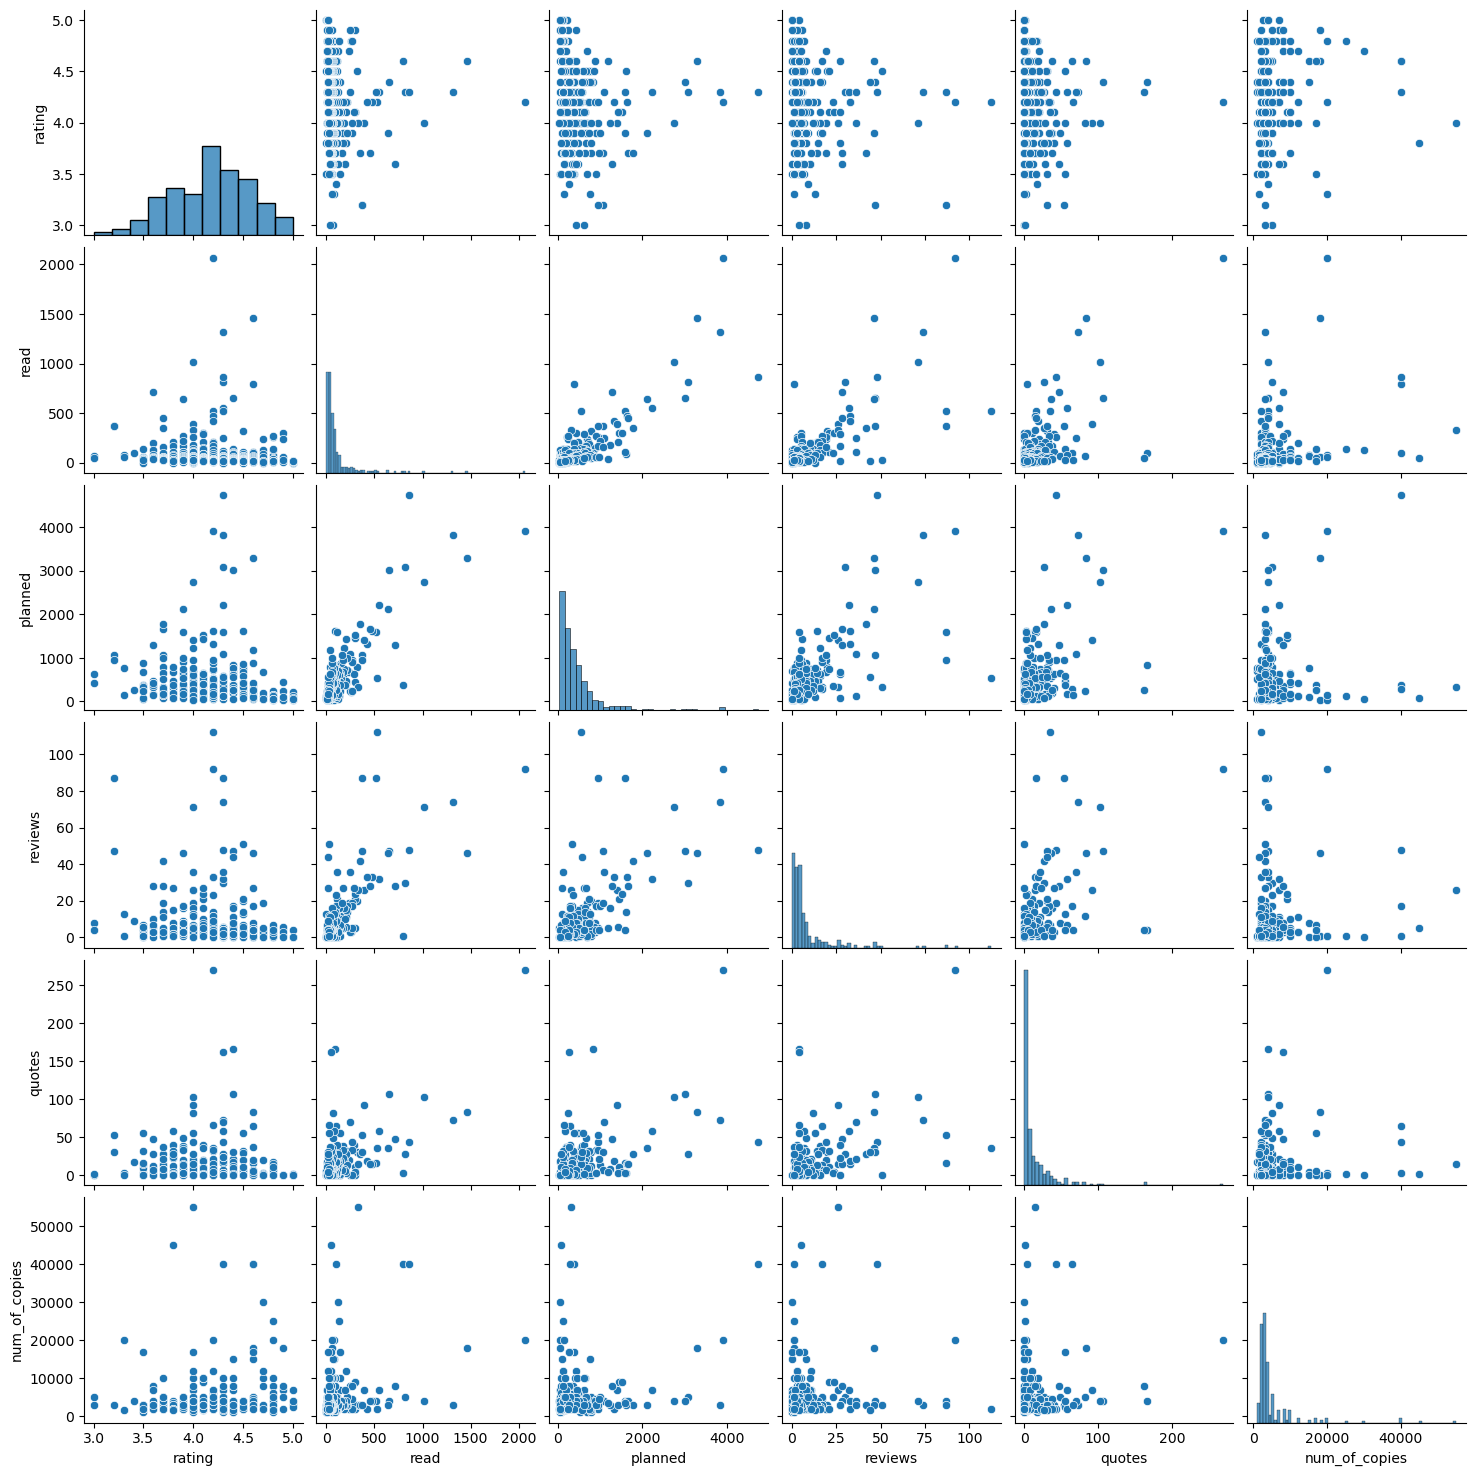

In [454]:
print(df[["rating", "read", "planned", "reviews", "quotes"]].corrwith(df['num_of_copies']))
sns.pairplot(df[["rating", "read", "planned", "reviews", "quotes", 'num_of_copies']])

Мы видим довольно слабую корреляцию, хотя корреляция тиража и количества читателей почти 0.3, что говорит о хоть какой-то зависимости. Но можно заметить, что на большинстве диаграмм точки сосредоточены ближе к началу координат и есть буквально по десятку точек, расположенных в осташихся 70% плоскости. Попробуем удалить выбросы с помощью межквартильного диапазона (измерение считается выбросом, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль, или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1))

In [455]:
def data_clean(df, columns):
    for column in columns:
        Q1 = df[column].quantile(q=.25)
        Q3 = df[column].quantile(q=.75)
        IQR = Q3 - Q1
        df = df[(df[column] < Q3 + 1.5*IQR) & (df[column] > Q1 - 1.5*IQR)]
    return df

df_cleaned = data_clean(df, ["read", "planned", "reviews", "quotes"])
df_cleaned.reset_index(drop= True , inplace= True)
df_cleaned

,heading,author,ISBN,edition,age_limit,genre,language,cover_type,year,price,...,pages,weight,num_of_copies,rating,read,planned,reviews,quotes,discount,sale
0,Танго с демоном. Танго Нуэво,Галина Гончарова,978-5-17-153503-2,АСТ,16+,Романтическоефэнтези,Русский,Твердыйпереплёт,2023,466,...,416,330,2000.0,4.0,3,38,0,0,18.96,True
1,Завоеватель,Конн Иггульден,978-5-389-21864-2,Азбука,16+,Историческийроман,Русский,Твердыйпереплёт,2023,701,...,480,558,3000.0,4.3,3,49,0,0,12.27,True
2,Полые куклы,МарсиКейт Коннолли,978-5-04-114191-2,Эксмо,12+,Детскаяфантастика,Русский,Твердыйпереплёт,2022,443,...,352,350,2000.0,3.8,2,116,1,5,18.72,True
3,"Тело, эмоции, отношения, ты: Красивая книга о ...",Барбара Петрущак,978-5-00195-565-8,Эксмо,16+,Детскаяпознавательнаяиразвивающаялитература,Русский,Твердыйпереплёт,2022,814,...,208,400,4500.0,4.3,3,143,0,0,17.61,True
4,"Одна ночь с женщиной, которая меня любила",Вячеслав Прах,978-5-17-152426-5,АСТ,18+,Современныелюбовныероманы,Русский,Твердыйпереплёт,2023,466,...,224,248,7000.0,5.0,3,44,0,0,18.96,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Моё настоящее имя. Истории с биографией,Людмила Улицкая,978-5-17-153632-9,АСТ,18+,Современнаярусскаялитература,Русский,Твердыйпереплёт,2023,797,...,285,320,17000.0,4.6,15,259,4,5,18.26,True
191,Предвестники Мельтиара,Влада Медведникова,978-5-6048361-9-4,PopcornBooks,18+,Современнаярусскаялитература,Русский,Мягкийпереплет,2023,424,...,336,306,10000.0,3.7,24,165,3,8,31.94,True
192,Бэнкси,Березанская Мария,978-5-17-149357-8,АСТ,12+,Биографииимемуары,Русский,NaN,2022,484,...,160,200,2000.0,4.7,12,49,0,0,18.66,True
193,Любовь внутри. Путь от одиночества к по-настоя...,Юн Кан Чэнь,978-5-9614-8064-1,АльпинаПаблишер,12+,Книгипопсихологии,Русский,Твердыйпереплёт,2023,491,...,204,400,2000.0,3.5,28,231,1,0,36.97,True


Почти 80 строк были отфильтрованы, проверим теперь корреляцию между теми же переменными и построим диаграммы рассеяния

rating     0.119796
read       0.187297
planned   -0.131501
reviews   -0.026147
quotes    -0.093979
dtype: float64


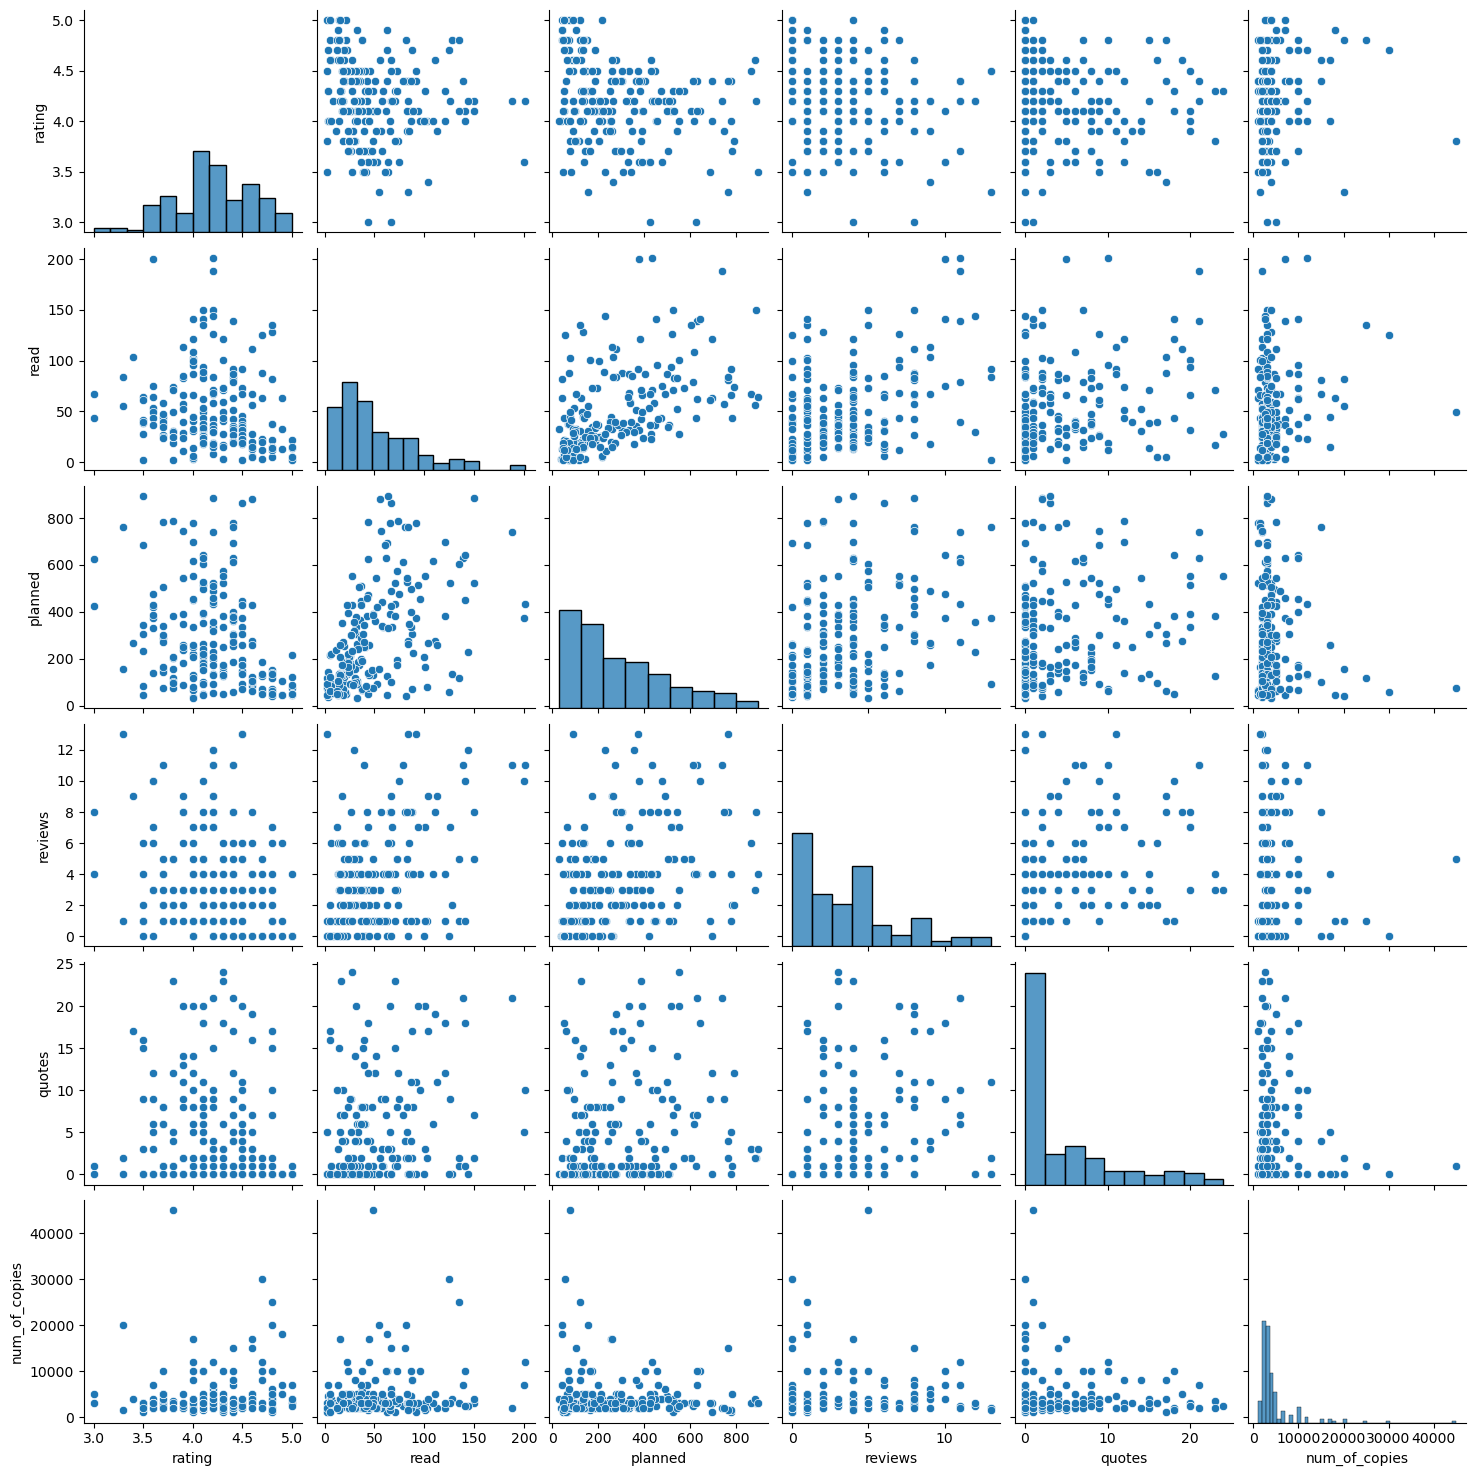

In [456]:
print(df_cleaned[["rating", "read", "planned", "reviews", "quotes"]].corrwith(df_cleaned['num_of_copies']))
sns.pairplot(df_cleaned[["rating", "read", "planned", "reviews", "quotes", 'num_of_copies']])

Как видно, коэффициент корреляции стал ещё меньше по модулю, значит данные величины не взаимосвязаны.

### Гипотеза 4

_**Стоимость книг подвержена нормальному распределению**_

Сравним внешний вид распределения стоимости книг с нормальным распределением

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Price distribution')]

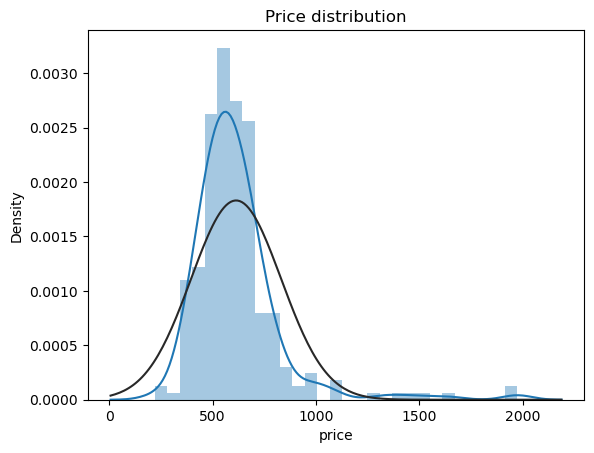

In [457]:
sns.distplot(df.price.dropna(), fit=norm).set(title='Price distribution')

В целом можно заметить, что распределение похоже на нормальное, в нашем случае "колокол" немного смещён влево и вытянут, но можно сказать, что стоимость книг подчиняется закону нормального распределения

### Гипотеза 5

_**Вес книги зависит от количества страниц**_

Построим диаграмму рассеяния цены и массы и найдём коэффициент корреляции

pages    0.594709
dtype: float64


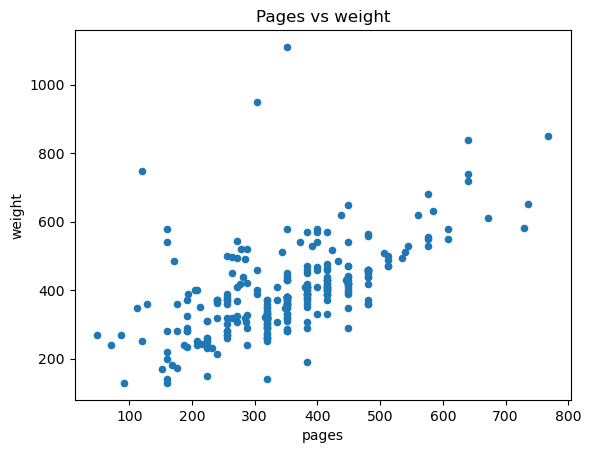

In [472]:
df.plot('pages', 'weight', kind='scatter', title="Pages vs weight")
print(df[['pages']].corrwith(df['weight']))

Коэффициент корреляции больше 0.5, что говорит о том, что присутствует средняя прямая корреляция (что в принципе логично, потому что чем больше бумаги, тем больше её вес)

### Гипотеза 6

_**Распределение ограничений по возрасту книг зависит от издательства.**_

Для исследования отберём самые распространённые издательства, в данном случае это Эксмо, АСТ, Азбука и Манн,ИвановиФербер
Составим сводную таблицу по этим данным

In [459]:
df.edition.value_counts()

Эксмо                       85
АСТ                         64
Азбука                      23
Манн,ИвановиФербер          19
Альпинанон-фикшн             9
Питер                        7
АльпинаПаблишер              7
INSPIRIA                     7
Бомбора                      6
РОСМЭН                       6
Freedom                      5
КоЛибри                      5
Livebook                     4
Городец                      3
Синдбад                      3
Стрекоза                     2
Иностранка                   2
КомпасГид                    2
ФантомПресс                  1
Фабрикакомиксов              1
Рипол-Классик                1
AdMarginemPress              1
Махаон                       1
ИздательствоИванаЛимбаха     1
AltGraph                     1
Альпина.Проза                1
PopcornBooks                 1
LikeBook                     1
Fanzon                       1
Дримбук                      1
Name: edition, dtype: int64

In [460]:
df_editions = df[df['edition'].isin(["Эксмо", "АСТ", "Азбука", "Манн,ИвановиФербер"])]
pd.crosstab(df_editions['age_limit'], df_editions['edition'], margins=True, margins_name='Total', normalize='columns')

edition,АСТ,Азбука,"Манн,ИвановиФербер",Эксмо,Total
age_limit,,,,,
0+,0.000000,0.043478,0.052632,0.000000,0.010471
12+,0.031250,0.043478,0.157895,0.094118,0.073298
16+,0.578125,0.695652,0.578947,0.670588,0.633508
18+,0.390625,0.217391,0.210526,0.235294,0.282723


В целом распределение довольно равномерное, но книги 0+ и 12+ в большинстве своём изданы издательством Манн,ИвановиФербер, 16+ - Азбукой и Эксмо, а книг 18+ больше всего у издательства АСТ. Из этого можно сделать вывод, что в некоторой степени возрастные ограничения зависят от издательства

### Гипотеза 7

_**Стоимость книги зависит от типа обложки**_

Составим сводную таблицу по статистическим данным цены и с группировкой по типу обложки

In [461]:
df.groupby('cover_type')[['price']].agg(['count', 'mean', 'std', 'min', 'median', 'max']).T

cover_type    Интегральныйперепле  Мягкийпереплет  Твердыйпереплёт
price count              3.000000       19.000000       235.000000
      mean             436.000000      533.473684       623.029787
      std              180.277564      149.292542       227.182716
      min              236.000000      220.000000       337.000000
      median           486.000000      520.000000       586.000000
      max              586.000000      788.000000      1974.000000

Твёрдый переплёт дороже мягкого, который в свою очередь дороже интегрального. Может быть дело в количестве страниц, поэтому проверим это. 

In [462]:
df.groupby('cover_type')[['pages']].agg(['count', 'mean', 'std', 'min', 'median', 'max']).T

cover_type    Интегральныйперепле  Мягкийпереплет  Твердыйпереплёт
pages count              3.000000       19.000000       235.000000
      mean             242.666667      272.210526       357.468085
      std              150.164354       98.760979       116.538290
      min              152.000000      128.000000        49.000000
      median           160.000000      240.000000       352.000000
      max              416.000000      448.000000       768.000000

Получили аналогичный результат по количеству страниц. Осталось проверить, связаны ли количество страниц и стоимость книги. Найдём коэффициент корреляции

In [463]:
print(df[['pages']].corrwith(df['price']))

pages   -0.023891
dtype: float64


Получили, что корреляция практически нулевая, что говорит о том, что зависимости стоимости от количества страниц нет, значит, стоимость книги на самом деле зависит от типа переплёта

### Гипотеза 8

_**Наличие скидки зависит от издательства**_

Для исследования отберём 15 самых распространённых издательств.
Составим столбиковую диаграмму с группировкой по наличию скидки

C:\Users\Алёна\AppData\Local\Temp\ipykernel_38780\3957507970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_editions["edition"] = df_editions["edition"].astype('string')
C:\Users\Алёна\AppData\Local\Temp\ipykernel_38780\3957507970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_editions["edition"] = df_editions["edition"].astype('category')


<AxesSubplot:title={'center':'Editions vs discounts'}, xlabel='edition'>

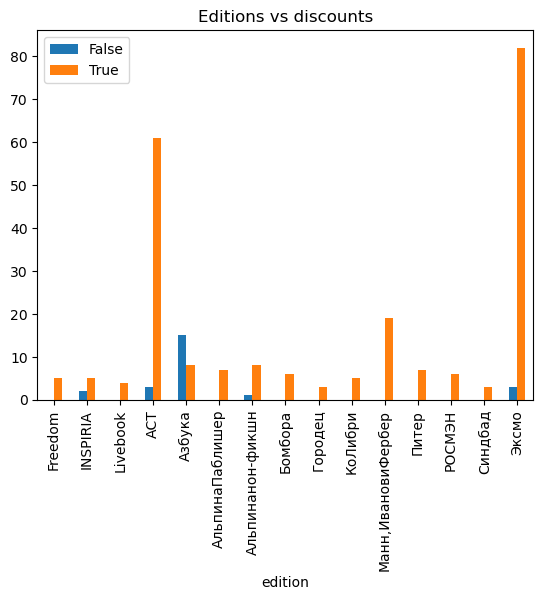

In [464]:
editions = df['edition'].value_counts().to_frame()[:15].index.tolist()
df_editions = df[df['edition'].isin(editions)]
df_editions["edition"] = df_editions["edition"].astype('string')
df_editions["edition"] = df_editions["edition"].astype('category')
df_editions.groupby(['edition'])['sale'].value_counts().unstack().plot(kind='bar', title='Editions vs discounts')

Можно заметить, что книги десяти издательств все со скидкой, четырёх - почти всех, за исключением буквально 1-3, а вот у издательства Азбука буквально треть книг со скидкой. Значит, наличие скидки на сайте читай города зависит от издательства

### Гипотеза 9

_**Процент скидки зависит от первоначальной стоимостт**_

Найдём коэффициент корреляции скидки и первоначальной стоимости, а также построим диаграмму рассеяния

discount   -0.563201
dtype: float64


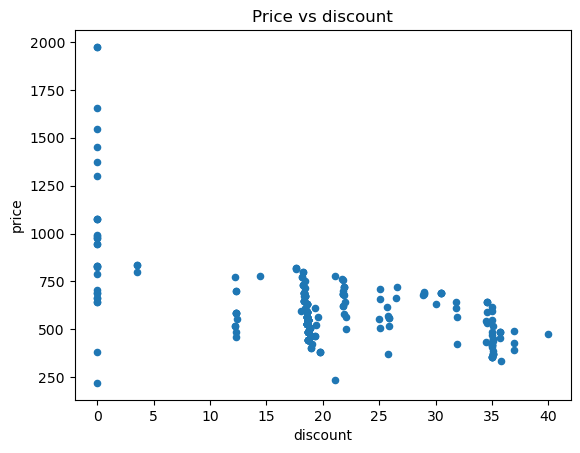

In [471]:
df.plot('discount', 'price', kind='scatter', title="Price vs discount")
print(df[['discount']].corrwith(df['price']))

Модуль коэффициента корреляции больше 0.5, что говорит о средней корреляции, а знак отрицательный, поэтому величины обратно зависимы. То есть чем больше цена, тем меньше итоговая скидка

### Гипотеза 10

_**Более качественные (читаемые и высоко оцененные) книги стоят дороже**_

Найдём коэффициент корреляции между ценой и разными статистическими данными качества книги

In [466]:
print(df[["rating", "read", "planned", "reviews", "quotes"]].corrwith(df['price']))

rating     0.176852
read      -0.002163
planned   -0.063926
reviews   -0.089957
quotes    -0.098284
dtype: float64


Коэффициент корреляции близок к нулю, только у рейтинга есть подозрение на зависимость от стоимости (или наоборот), поэтому гипотеза неверна.

Выведем сводную статистику по всем количественным данным датасета

In [467]:
df.describe()

,price,old_price,pages,weight,num_of_copies,rating,read,planned,reviews,quotes,discount
count,271.000000,271.000000,271.000000,271.000000,263.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000
mean,613.542435,757.107011,349.859779,394.221402,5217.490494,4.178598,120.073801,490.033210,9.228782,13.889299,19.599963
std,218.344336,205.291030,119.491526,128.525206,6763.056229,0.399239,220.191537,633.083151,15.472774,27.487956,9.599275
min,220.000000,220.000000,49.000000,129.000000,1000.000000,3.000000,2.000000,31.000000,0.000000,0.000000,0.000000
25%,485.000000,645.000000,272.000000,319.000000,2500.000000,3.900000,27.000000,139.500000,2.000000,0.000000,18.360000
50%,568.000000,725.000000,352.000000,380.000000,3000.000000,4.200000,54.000000,300.000000,4.000000,4.000000,18.660000
75%,684.000000,845.000000,416.000000,451.000000,5000.000000,4.500000,108.500000,570.000000,8.000000,16.000000,21.885000
max,1974.000000,1974.000000,768.000000,1110.000000,55000.000000,5.000000,2069.000000,4743.000000,112.000000,270.000000,40.000000


Составим тепловую карту корреляции между числовыми данными датасета. Все воможные корреляции между величинами мы учли в наших гипотезах

<AxesSubplot:>

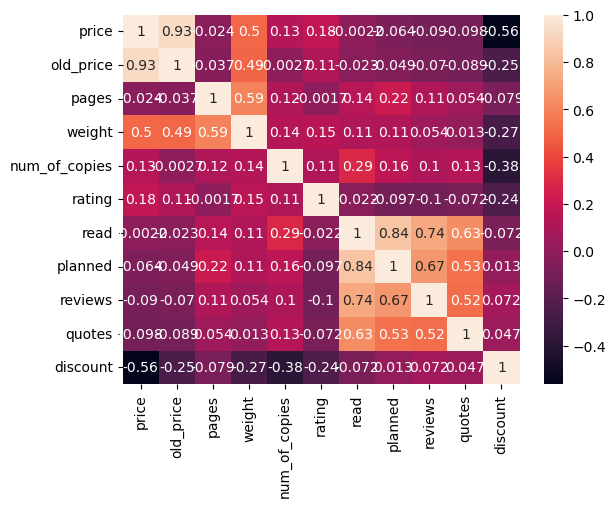

In [468]:
sns.heatmap(df.corr(), annot=True)

Также можно составить диаграммы рассеяния попарно между всеми количественными величинами

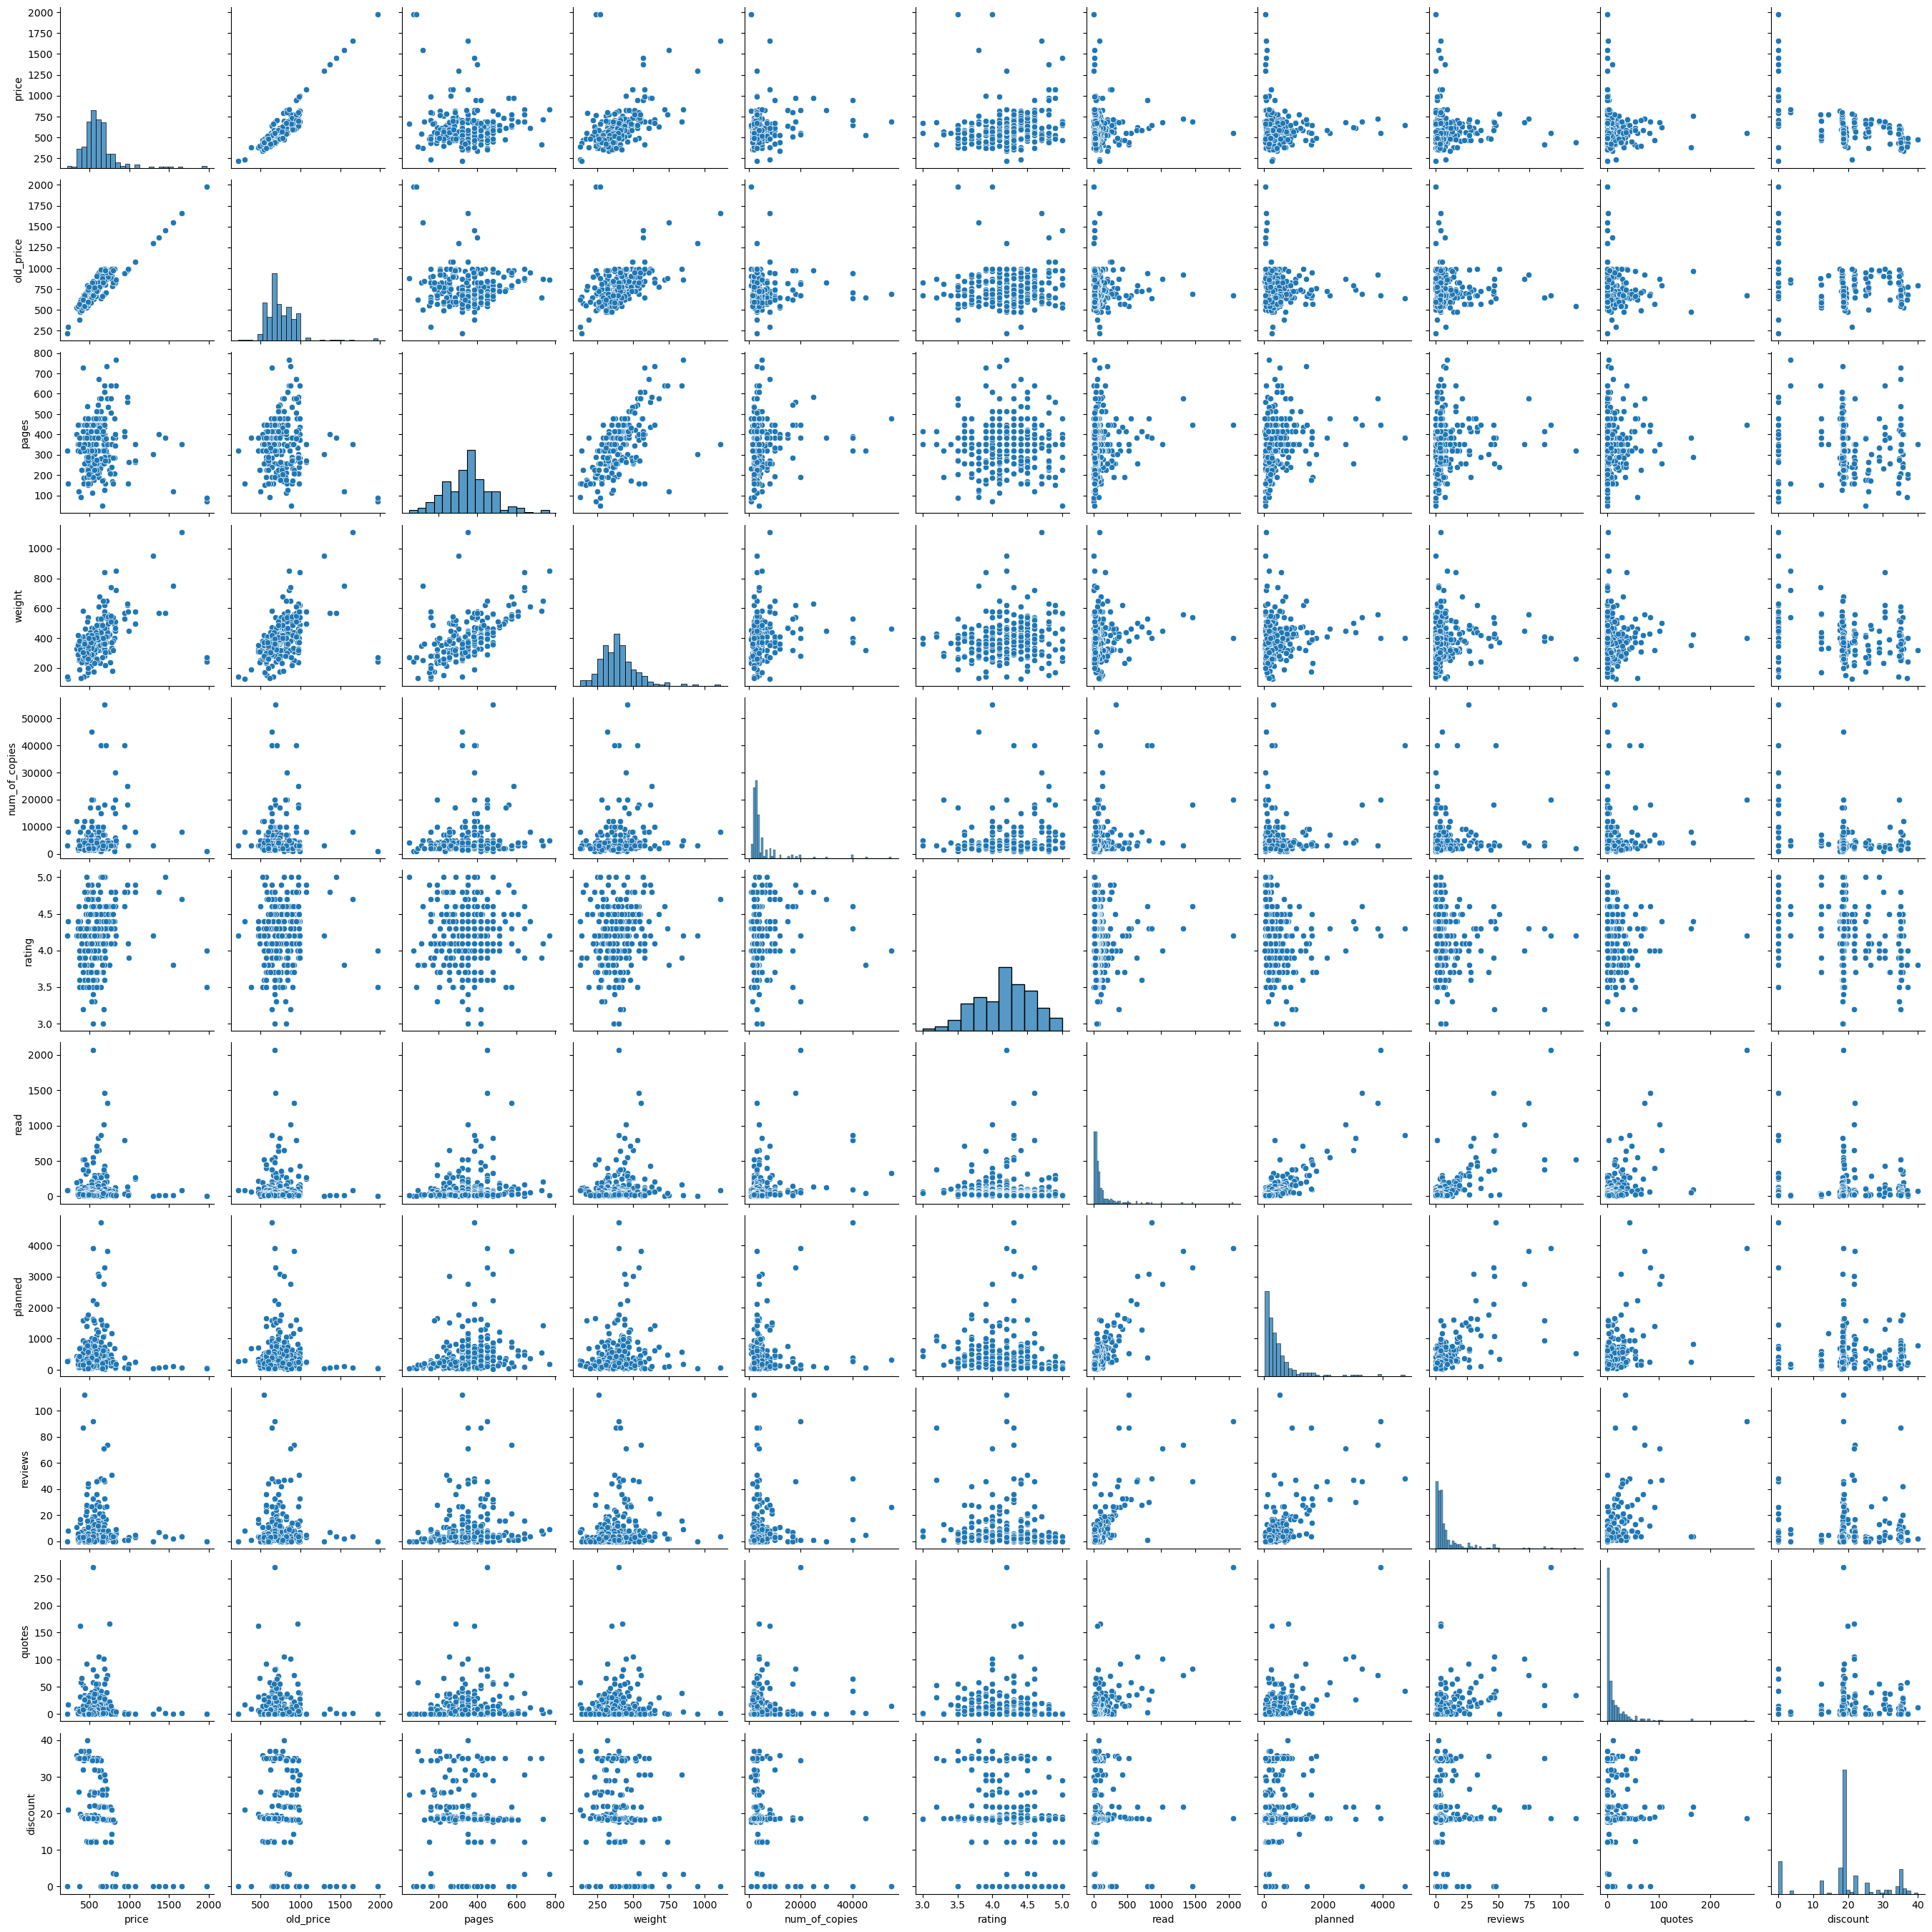

In [469]:
sns.pairplot(df[["price", "old_price", "pages", "weight", "num_of_copies", "rating", "read", "planned", "reviews", "quotes", "discount"]])

## Выводы

В данном исследовании были собраны данные о популярных книгах, а затем выявлены зависимости между этими данными. Были подтверждены 8 гипотез из 10, что говорит о том, что почти все мои предположения были верны. 
Были выявлены наиболее популярные жанры, зависимость веса книги от количества страниц, стоимости от обложки, наличия скидки от издательства и процента скидки от первоначальной стоимости. Я считаю, что цель исследования выполнена и задачи достигнуты

In [1]:
def f(x):
    return x**4 - 6 * x**3 + 9 * x**2 - 2 * x - 3

def sign(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
    else:
        return 0

eps = 1e-6
l = -1 - eps
r = 0 + eps

while l + eps < r:
    m = (l + r) / 2
    if sign(f(l)) == sign(f(m)):
        l = m
    else:
        r = m

print(f'root is {l:.6f}')
print(f'precise value is {f(l):.6f}')

root is -0.427352
precise value is 0.000006
